In [159]:
import pandas as pd
import json
import requests
import gmaps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import math
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import numpy as np 
from sklearn.neighbors import NearestNeighbors
import pandas as pd

In [120]:
pedestrian_df = pd.read_csv("/media/mufaddal/share/documents/NUI Galway/academics/Major Project/Thesis/data/Pedestrian_Counting_System.csv")

#Data manipulation
pedestrian_df = pedestrian_df[np.isin(pedestrian_df.Year,[2017,2018,2019])]
pedestrian_df['ds'] = pedestrian_df.Date_Time.apply(lambda x: x[6:10]+ "-" + x[0:2] + "-" + x[3:5] + x[10:22]).astype('datetime64')
pedestrian_df['Hourly_Counts'] = pedestrian_df.Hourly_Counts.apply(lambda x: x.replace(',', '')).astype('int')
pedestrian_df.rename(columns = {'Hourly_Counts':'y'}, inplace = True)

#select data for test and train
pedestrian_data = pedestrian_df[pedestrian_df.Year == 2017]
pedestrian_data_test = pedestrian_df[pedestrian_df.Year == 2018]

In [121]:

# making prediction ready dataframes
footfall = pedestrian_data
footfall['cap'] = 3000
footfall['floor'] = 0

#seggregating data for each of the sensors
sensor21 = footfall.loc[footfall.Sensor_ID == 21,["ds","y","cap","floor"]]
sensor20 = footfall.loc[footfall.Sensor_ID == 20,["ds","y","cap","floor"]]
sensor30 = footfall.loc[footfall.Sensor_ID == 30,["ds","y","cap","floor"]]
sensor40 = footfall.loc[footfall.Sensor_ID == 40,["ds","y","cap","floor"]]
sensor19 = footfall.loc[footfall.Sensor_ID == 19,["ds","y","cap","floor"]]
sensor52 = footfall.loc[footfall.Sensor_ID == 52,["ds","y","cap","floor"]]
sensor2 = footfall.loc[footfall.Sensor_ID == 2,["ds","y","cap","floor"]]



/home/mufaddal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<h2> Data Exploration : </h2>

Below is the shape of the data for year 2017, this will be used as training data

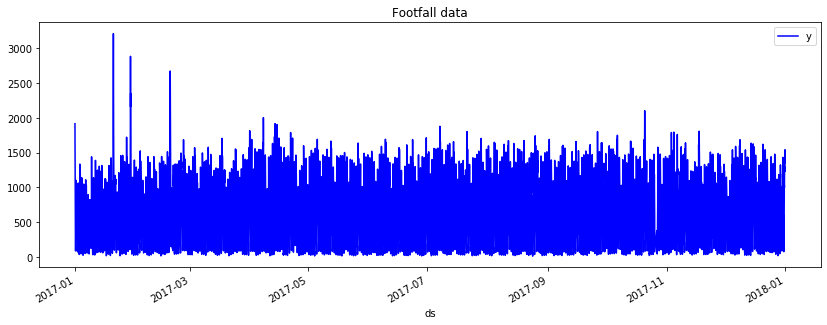

In [166]:
sensor21_data = pedestrian_df[pedestrian_df.Sensor_ID == 21]
sensor21_17 = sensor21_data[sensor21_data.Year == 2017]
sensor21_18 = sensor21_data[sensor21_data.Year == 2018]

sensor34_data = pedestrian_df[pedestrian_df.Sensor_ID == 34]
sensor34_19 = sensor34_data[sensor34_data.Year == 2019]

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21_17.plot(kind='line', x='ds', y='y', color='blue', ax=ax)
plt.title('Footfall data')
plt.show()


In [156]:
#identifying high footfall days :


print("Sensor 21 for year 2017")
temp = sensor21_17[sensor21_17.y > 1800]['Date_Time'].apply(lambda x: x[0:10]).to_frame()
print(temp.groupby('Date_Time').size())

#Comparision with other sensor and different year's data
print("\n\nSensor 34 for year 2019")
sensor34_data = pedestrian_df[pedestrian_df.Sensor_ID == 34]
sensor34_19 = sensor34_data[sensor34_data.Year == 2019]


temp = sensor34_19[sensor34_19.y > 1500]['Date_Time'].apply(lambda x: x[0:10]).to_frame()
temp.groupby('Date_Time').size()

Sensor 21 for year 2017
Date_Time
01/01/2017    1
01/20/2017    6
01/29/2017    6
02/18/2017    5
02/19/2017    3
03/31/2017    2
04/07/2017    2
04/13/2017    1
04/14/2017    1
07/07/2017    1
07/21/2017    1
09/26/2017    1
10/20/2017    3
11/17/2017    1
dtype: int64


Sensor 34 for year 2019


Date_Time
08/22/2019    1
08/23/2019    5
08/24/2019    1
09/20/2019    4
09/27/2019    1
10/13/2019    1
dtype: int64

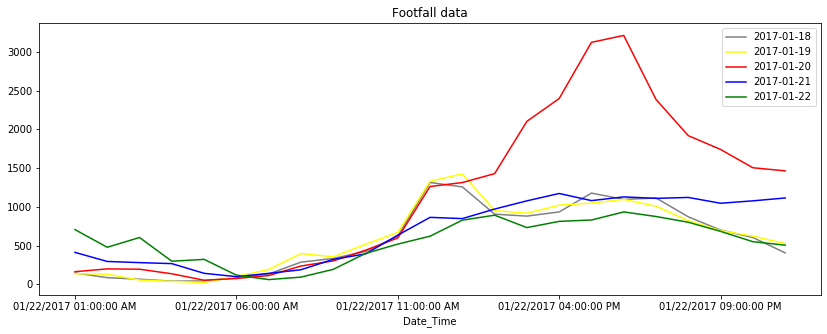

In [141]:
#demonstrating sudden spikes in footfall for some specific time of day on which some important event occured.

sensor21_18_17_df = sensor21_17[sensor21_17.ds > "2017-01-18 00:00:00"]
sensor21_18_17_df = sensor21_18_17_df[sensor21_18_17_df.ds < "2017-01-19 00:00:00"]

sensor21_17_17_df = sensor21_17[sensor21_17.ds > "2017-01-19 00:00:00"]
sensor21_17_17_df = sensor21_17_17_df[sensor21_17_17_df.ds < "2017-01-20 00:00:00"]

sensor21_20_17_df = sensor21_17[sensor21_17.ds > "2017-01-20 00:00:00"]
sensor21_20_17_df = sensor21_20_17_df[sensor21_20_17_df.ds < "2017-01-21 00:00:00"]

sensor21_21_17_df = sensor21_17[sensor21_17.ds > "2017-01-21 00:00:00"]
sensor21_21_17_df = sensor21_21_17_df[sensor21_21_17_df.ds < "2017-01-22 00:00:00"]

sensor21_22_17_df = sensor21_17[sensor21_17.ds > "2017-01-22 00:00:00"]
sensor21_22_17_df = sensor21_22_17_df[sensor21_22_17_df.ds < "2017-01-23 00:00:00"]

#Plotting comparative data

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21_18_17_df.plot(kind='line', x='Date_Time', y='y', color='grey', ax=ax, label='2017-01-18')
sensor21_17_17_df.plot(kind='line', x='Date_Time', y='y', color='yellow', ax=ax, label='2017-01-19')
sensor21_20_17_df.plot(kind='line', x='Date_Time', y='y', color='red', ax=ax, label='2017-01-20')
sensor21_21_17_df.plot(kind='line', x='Date_Time', y='y', color='blue', ax=ax, label='2017-01-21')
sensor21_22_17_df.plot(kind='line', x='Date_Time', y='y', color='green', ax=ax, label='2017-01-22')


plt.title('Footfall data')
plt.show()



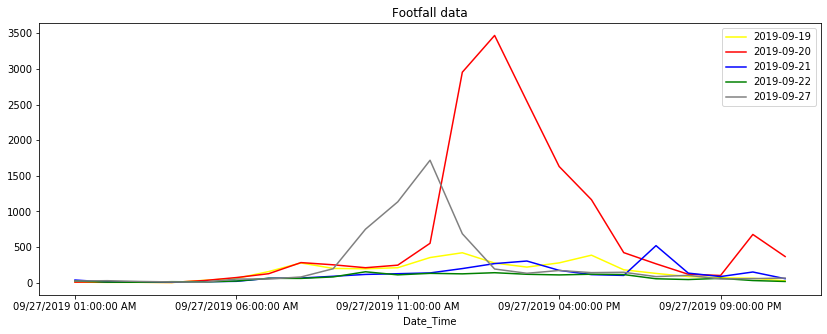

In [157]:
#Comparision with different sensor's data 

sensor34_data = pedestrian_df[pedestrian_df.Sensor_ID == 34]
sensor34_19 = sensor34_data[sensor34_data.Year == 2019]

sensor34_19_19_df = sensor34_19[sensor34_19.ds > "2019-09-19 00:00:00"]
sensor34_19_19_df = sensor34_19_19_df[sensor34_19_19_df.ds < "2019-09-20 00:00:00"]

sensor34_20_19_df = sensor34_19[sensor34_19.ds > "2019-09-20 00:00:00"]
sensor34_20_19_df = sensor34_20_19_df[sensor34_20_19_df.ds < "2019-09-21 00:00:00"]

sensor34_21_19_df = sensor34_19[sensor34_19.ds > "2019-09-21 00:00:00"]
sensor34_21_19_df = sensor34_21_19_df[sensor34_21_19_df.ds < "2019-09-22 00:00:00"]

sensor34_22_19_df = sensor34_19[sensor34_19.ds > "2019-09-22 00:00:00"]
sensor34_22_19_df = sensor34_22_19_df[sensor34_22_19_df.ds < "2019-09-23 00:00:00"]

sensor34_28_19_df = sensor34_19[sensor34_19.ds > "2019-09-27 00:00:00"]
sensor34_28_19_df = sensor34_28_19_df[sensor34_28_19_df.ds < "2019-09-28 00:00:00"]

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor34_19_19_df.plot(kind='line', x='Date_Time', y='y', color='yellow', ax=ax, label='2019-09-19')
sensor34_20_19_df.plot(kind='line', x='Date_Time', y='y', color='red', ax=ax, label='2019-09-20')
sensor34_21_19_df.plot(kind='line', x='Date_Time', y='y', color='blue', ax=ax, label='2019-09-21')
sensor34_22_19_df.plot(kind='line', x='Date_Time', y='y', color='green', ax=ax, label='2019-09-22')
sensor34_28_19_df.plot(kind='line', x='Date_Time', y='y', color='grey', ax=ax, label='2019-09-27')
plt.title('Footfall data')
plt.show()


<h3> Google Map APIs </h3>

In [202]:

gmaps.configure(api_key="API Key Goes Here")

data = pd.read_csv("/media/mufaddal/share/documents/NUI Galway/academics/Major Project/Thesis/data/Unique_sensor.csv",sep="\t")

lat_long = list(zip(data.latitude, data.longitude))

figure_lyt = {
    'width':'800px',
    'height':'800px',
    'padding':'3px'
}
fig = gmaps.figure(layout = figure_lyt)
markers = gmaps.marker_layer(lat_long,hover_text=data.Sensor_Name,label=data.Sensor_ID.astype(str))
fig.add_layer(markers)
fig


Figure(layout=FigureLayout(height='800px', padding='3px', width='800px'))

<h3> Correlation Matrix : </h3>

/home/mufaddal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


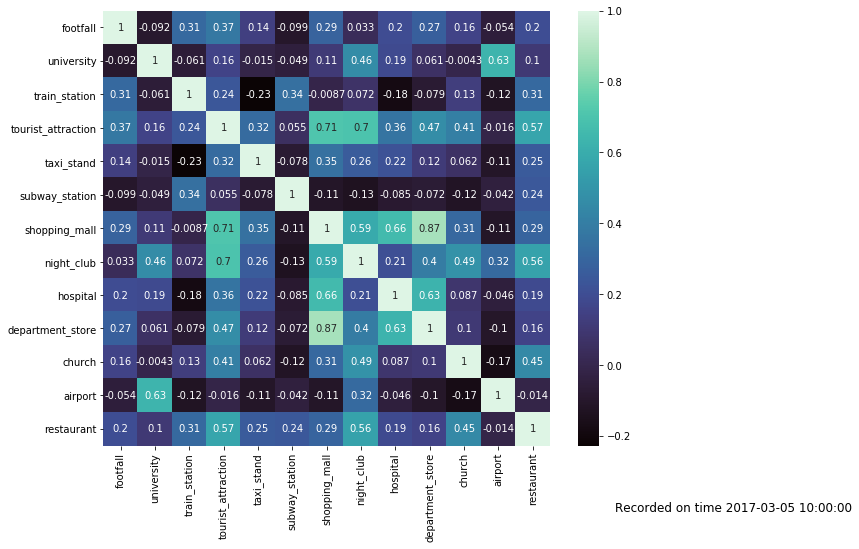

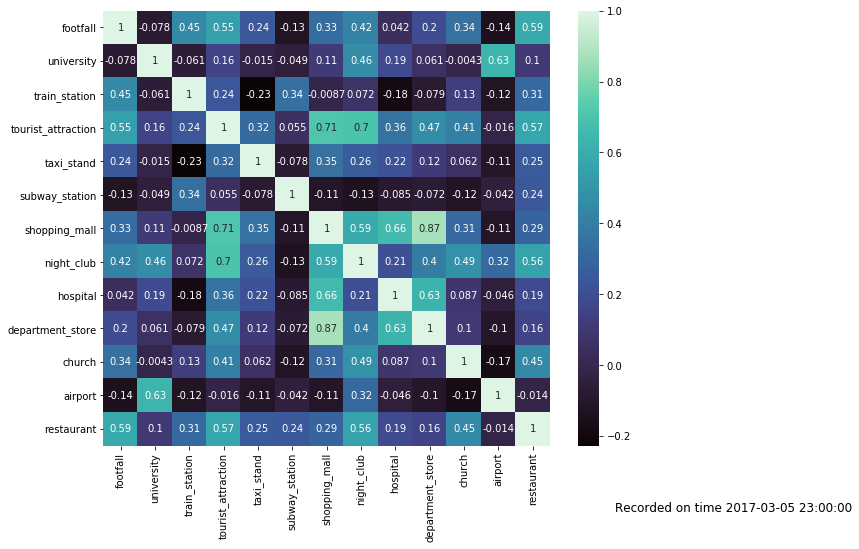

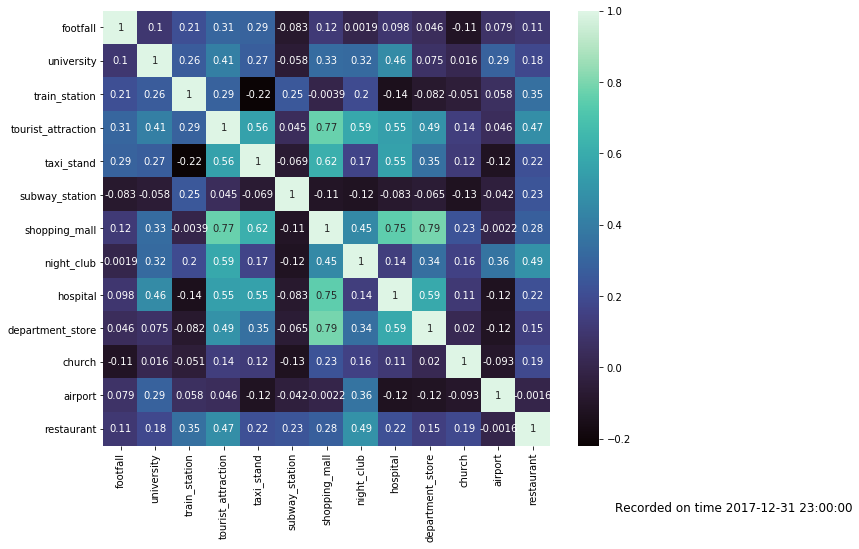

In [209]:
time_sample = ['2017-03-05 10:00:00', '2017-03-05 23:00:00', '2017-12-31 23:00:00']

for time in time_sample:
    
    Selected_data = pedestrian_data[pedestrian_data.ds == time]
    Selected_data.rename(columns = {'y':'footfall'}, inplace = True)  
    pedestrian_data_df = Selected_data[['ds','footfall','Sensor_ID']]
    All_sensor_features = pd.merge(pedestrian_data_df,Sensor_Features,on='Sensor_ID',how='inner')
    cols = All_sensor_features.columns.tolist()
    cols.remove('ds')
    cols.remove('Sensor_ID')
    cols

    corrMatrix = All_sensor_features.loc[:,cols].corr(method ='pearson')

    plt.figure(figsize=(10,8))
    sn.heatmap(corrMatrix, annot=True,cmap="mako")
    plt.figtext(1, 0.01, "Recorded on time "+time, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

<h2> Temporal Analysis : </h2>

In [163]:

sensor21_17['cap'] = 3000
sensor21_17['floor'] = 0
m = Prophet(growth = 'logistic')
m.add_country_holidays(country_name='AU')
m.add_seasonality(name='daily', period=1, fourier_order=2)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_seasonality(name='monthly', period=30, fourier_order=5)
m.add_seasonality(name='yearly', period=365, fourier_order=5)
m.fit(sensor21_17)


/home/mufaddal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


In [164]:
future = m.make_future_dataframe(periods=365)
future['cap'] = 3000
future['floor'] = 0
future

,ds,cap,floor
0,2017-01-01 00:00:00,3000,0
1,2017-01-01 01:00:00,3000,0
2,2017-01-01 02:00:00,3000,0
3,2017-01-01 03:00:00,3000,0
4,2017-01-01 04:00:00,3000,0
...,...,...,...
9095,2018-12-27 23:00:00,3000,0
9096,2018-12-28 23:00:00,3000,0
9097,2018-12-29 23:00:00,3000,0
9098,2018-12-30 23:00:00,3000,0


In [165]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-01 00:00:00,641.540830,369.851728,942.062498
1,2017-01-01 01:00:00,508.699291,217.561625,775.168179
2,2017-01-01 02:00:00,386.374416,91.643828,654.106465
3,2017-01-01 03:00:00,285.050299,3.589334,585.387559
4,2017-01-01 04:00:00,215.559521,-80.747823,481.672286


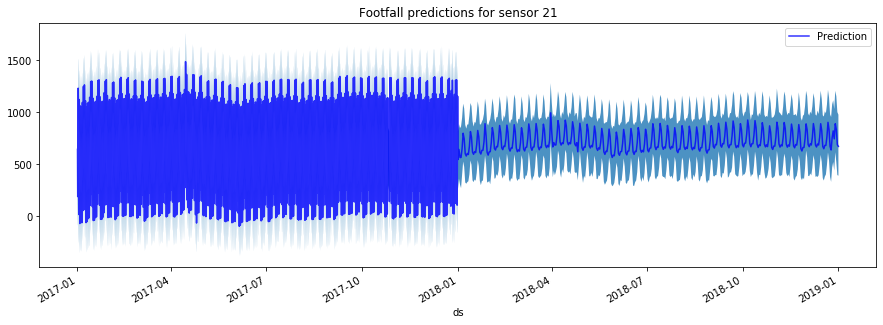

In [185]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast.plot(kind='line',x='ds',y='yhat' ,color='blue', label='Prediction', ax=ax,alpha=0.8)
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, alpha=0.8)
plt.title('Footfall predictions for sensor 21')
plt.show()

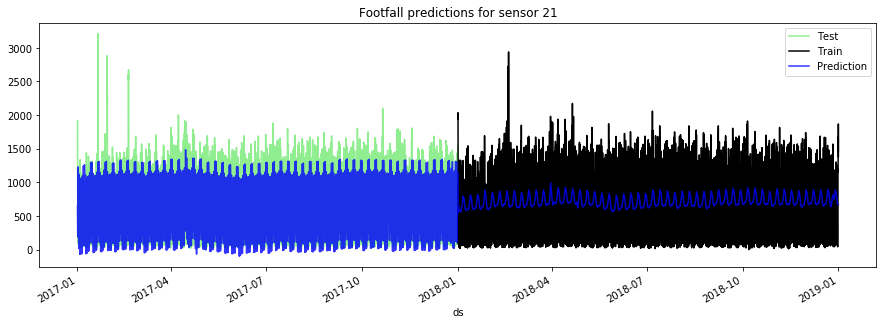

In [187]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
sensor21_17.plot(kind='line', x='ds', y='y', color='lightgreen', label='Test', ax=ax,alpha=1)
sensor21_18.plot(kind='line', x='ds', y='y', color='black', label='Train', ax=ax,alpha=1)
forecast.plot(kind='line',x='ds',y='yhat' ,color='blue', label='Prediction', ax=ax,alpha=0.8)
plt.title('Footfall predictions for sensor 21')
plt.show()

In [173]:
#Finding error in prediction as compared to actual data of 2018

tmp = pd.merge(forecast,sensor21_18 , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['yhat'])
cust_mse = np.sum(tmp['mse'])/len(tmp)
print(cust_mse)
mse = mean_squared_error(tmp['y'], tmp['yhat'])
rmse = math.sqrt(mse)
mae = np.sum(np.abs(tmp['y'] - tmp['yhat']))/len(tmp)
print(mae)
print(mse , rmse)


75903.48360490223
236.3417453152807
75903.48360490223 275.5058685489335


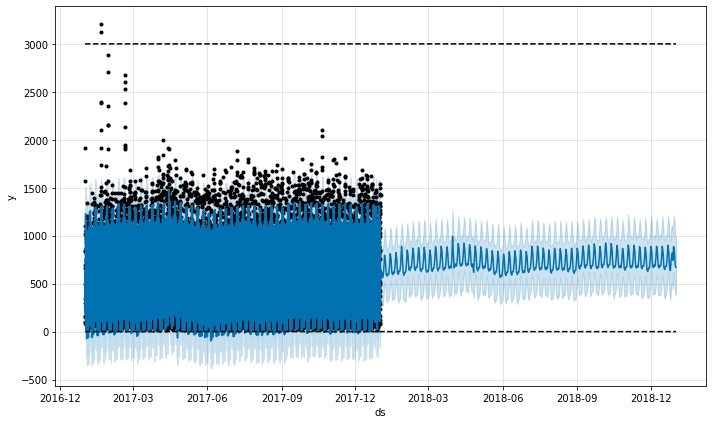

In [188]:
fig1 = m.plot(forecast)

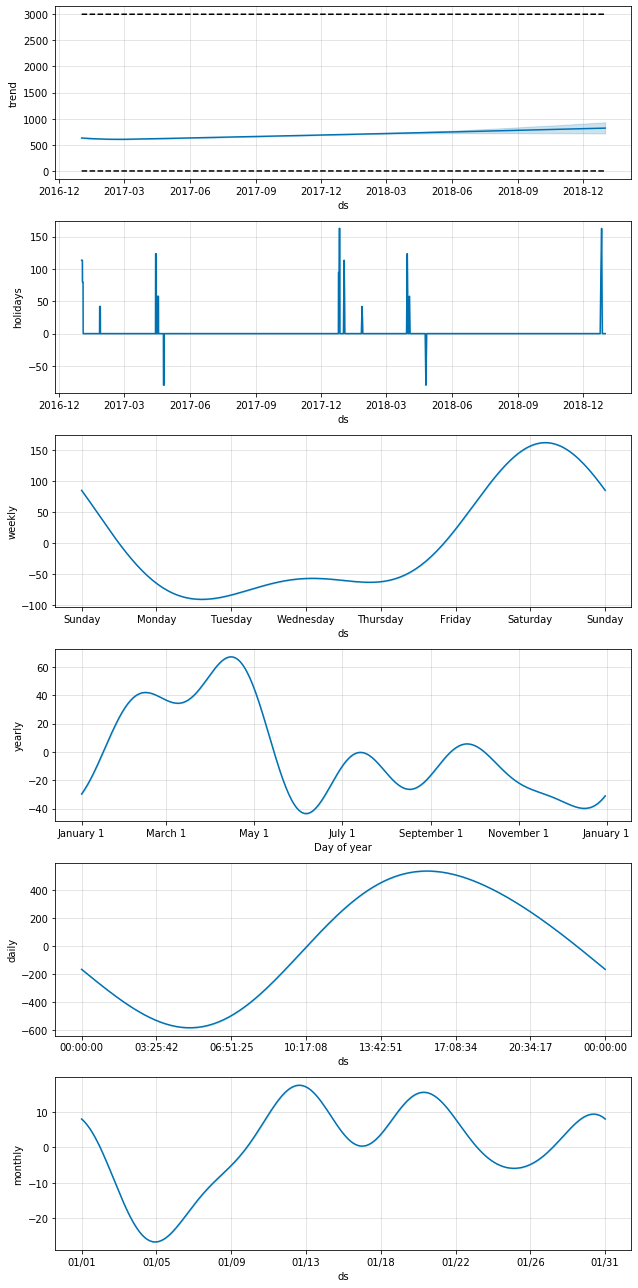

In [189]:
#Following is the breakup of the component wise trends and seasonalities
fig2 = m.plot_components(forecast)

In [190]:
#Following are the holidays model has considered
m.train_holiday_names

0               New Year's Day
1    New Year's Day (Observed)
2                Australia Day
3                  Good Friday
4                Easter Monday
5                    Anzac Day
6                Christmas Day
7                   Boxing Day
dtype: object

In [197]:
df_cv = cross_validation(m, initial='180 days', period='365 days', horizon = '30 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-12-01 23:00:00 and 2017-12-01 23:00:00


In [199]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days 00:00:00,68454.251646,261.637634,193.432506,0.542974,0.354352,0.750000
1,3 days 01:00:00,67995.919614,260.760272,191.841430,0.545211,0.366465,0.750000
2,3 days 02:00:00,67550.891730,259.905544,189.868980,0.543852,0.366465,0.750000
3,3 days 03:00:00,67423.919965,259.661164,188.973385,0.546191,0.371242,0.750000
4,3 days 04:00:00,67236.049658,259.299151,188.133620,0.565547,0.371242,0.750000
...,...,...,...,...,...,...,...
644,29 days 20:00:00,71598.312871,267.578611,223.632536,0.571365,0.351220,0.694444
645,29 days 21:00:00,80240.975329,283.268380,230.484530,0.574552,0.351220,0.694444
646,29 days 22:00:00,88268.045235,297.099386,237.410608,0.578186,0.351220,0.694444
647,29 days 23:00:00,105641.607455,325.025549,249.645445,0.583589,0.351220,0.680556


<h2> Geo - Temporal Analysis </h2>

In [ ]:

#code to download nearby Point of interest details

est_type = ['Sensor_ID',
            'airport',
             'church',
             'department_store',
             'hospital',
             'night_club',
             'shopping_mall',
             'subway_station',
             'taxi_stand',
             'tourist_attraction',
             'train_station',
             'university']

SensorProfile = pd.DataFrame(columns = est_type)
df = pd.DataFrame(columns = ['Sensor_ID','name', 'types', 'rating','num_rating','vicinity'])

for est_typ in est_type[1:]:
    
    for index in range(0 ,len(data)):
        max_page = 5
        next_page = "default"
        
        while(not (next_page is None) and max_page > 0):
#             print("max_page = ",max_page)
            params = {}
            params['location']= str(data.loc[index,"latitude"]) + "," + str(data.loc[index,"longitude"])  
            params['key']="API Key Goes Here "
            params['radius']="200"
            params['type']=est_typ
            if(next_page != "default"):
                params['next_page_token'] = next_page
#             print(params)
            response = requests.get(url='https://maps.googleapis.com/maps/api/place/nearbysearch/json',params=params)
            resp = response.json()
            results = resp.get('results')

            for item in results:
                df.loc[len(df)] = [
                                   data.loc[index,"Sensor_ID"], 
                                   item.get('name'),
                                   est_typ,
                                   item.get('rating'),
                                   item.get('user_ratings_total'),
                                   item.get('vicinity') ]

            next_page = resp.get('next_page_token')
#             print(next_page)
            max_page -= 1
            
        
print(df)


In [207]:
df=pd.read_csv("sensor_vicinity.csv",sep="\t")

types = np.unique(df.types).tolist()
types.remove('restaurant')
types

Restaurant_Count = df[(df.types ==  'restaurant') & (df.num_rating>200)].groupby(['Sensor_ID']).count()
Restaurant_Count = Restaurant_Count['name'].to_frame()
Restaurant_Count.rename(columns = {'name':'restaurant'}, inplace = True)
# print(Restaurant_Count)

Sensor_Features = Restaurant_Count

for typ in types:
    
    typ_count = df[df.types ==  typ].groupby(['Sensor_ID']).count()
    typ_count = typ_count['name'].to_frame()
    typ_count.rename(columns = {'name':typ}, inplace = True)
    Sensor_Features = pd.merge(typ_count,Sensor_Features,how='outer', on='Sensor_ID').fillna(0)
    

Sensor_Features = Sensor_Features.astype(int)
Sensor_Features['Sensor_ID'] = Sensor_Features.index
Sensor_Features.reset_index(drop=True, inplace=True)
Sensor_Features.head()



,university,train_station,tourist_attraction,taxi_stand,subway_station,shopping_mall,night_club,hospital,department_store,church,airport,restaurant,Sensor_ID
0,9,0,6,0,0,17,7,18,9,1,0,45,1
1,16,0,8,1,0,19,7,28,9,1,0,40,2
2,4,1,7,0,0,10,10,4,2,4,0,60,3
3,100,0,10,2,0,20,2,34,2,4,0,50,4
4,3,1,6,0,0,1,2,0,0,1,0,70,5


<h3> Finding Neighbors : </h3>

In [217]:
#Vicinity based neighbors 

x = Sensor_Features.drop('Sensor_ID', 1)
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean').fit(x)
distances, indices = nbrs.kneighbors(x)

iterator = zip(distances, indices)

f = lambda k: Sensor_Features.Sensor_ID[k].tolist()
Neighbor = {}
Neighbor_dist = {}
for i,item in enumerate(iterator):
    Neighbor[Sensor_Features.Sensor_ID[i]] = f(item[1][1:])
    Neighbor_dist[Sensor_Features.Sensor_ID[i]] = item[0][1:]
    
print("Location based neighbors\n")
print("Neighbors \n")
print(Neighbor_df.head())

Neighbor_df = pd.DataFrame.from_dict(Neighbor, orient='index',columns=['Neighbor1', 'Neighbor2', 'Neighbor3', 'Neighbor4'])
Neighbor_df['Sensor_ID'] = Neighbor_df.index
Neighbor_df.iloc[:,:]

Neighbor_dist_df = pd.DataFrame.from_dict(Neighbor_dist, orient='index',columns=['Neighbor1', 'Neighbor2', 'Neighbor3', 'Neighbor4'])
Neighbor_dist_df['Sensor_ID'] = Neighbor_dist_df.index
Neighbor_dist_df.iloc[:,:]
#location based neighbors 
print("\n\Distances of each neighbors\n")
print(Neighbor_dist_df.head())

Location based neighbors

Neighbors 

   Neighbor1  Neighbor2  Neighbor3  Neighbor4  Sensor_ID
1          2         45         19         55          1
2          1         45         62         18          2
3         15         19         14         24          3
4         36         56         22          2          4
5         31         37         50         35          5

\Distances of each neighbors

   Neighbor1  Neighbor2  Neighbor3  Neighbor4  Sensor_ID
1  13.527749  17.175564  18.627936  20.736441          1
2  13.527749  21.908902  29.291637  29.359837          2
3   2.236068  13.000000  14.035669  14.730920          3
4  35.425979  38.262253  39.025633  85.328776          4
5   6.708204   7.874008   9.848858  10.392305          5


/home/mufaddal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [267]:
#Location based neighbors

destinations = []
for elem in zip(data.latitude.astype(str), data.longitude.astype(str)):
    destinations.append(elem[0]+ "," + elem[1] + "|")

dest_part1 = "".join(destinations[:int(len(destinations)/2)])

dest_part2 = "".join(destinations[int(len(destinations)/2):])

dest = [dest_part1,dest_part2]

SensorDist = pd.DataFrame(columns = ['Sensor_ID', 'Distance'])
index = 0

for dest_part in dest:

    params = {}
    params['origins']= "-37.812447,144.967788"
    params['destinations']= dest_part
    params['key']="API Key Goes Here"
    params['mode'] = "walking"
    params['units'] = "metric"
    response = requests.get(url='https://maps.googleapis.com/maps/api/distancematrix/json',params=params)
    resp = response.json()

    rows = resp.get('rows')
    elem = rows[0].get('elements')

    for item in elem:
        SensorDist.loc[len(SensorDist)] = [data.Sensor_ID[index],
                   item.get('distance').get('value')               
                   ]
        index+=1


In [269]:
SensorDist.sort_values(by='Distance').head()

,Sensor_ID,Distance
48,21,0
24,20,134
14,30,236
29,19,256
22,2,322


<h3> Nearest Neighbors Vicinity </h3>

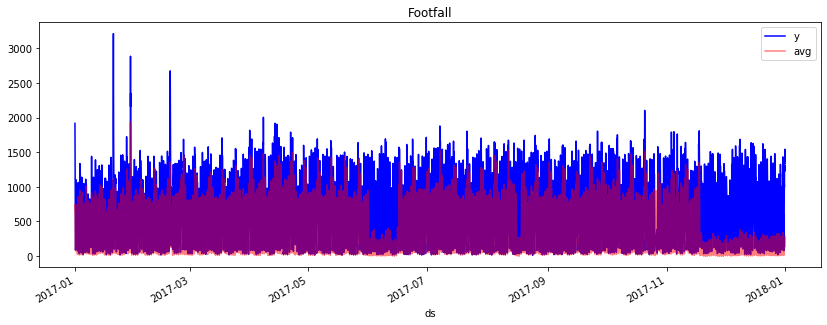

Mean Absolute Error =  239.18935317687465
Root Mean Square Error =  342.4988420171033


In [263]:
#K==2

#taking average
Neighbor_distance = Neighbor_dist_df.loc[21,:].tolist()[0:4]
all_sensor_df = pedestrian_data[pedestrian_data.Sensor_ID == Neighbor[21][0]]
all_sensor_df = all_sensor_df[['ds','y']]


for n in Neighbor[21][1:2]:

    sensor_df = pedestrian_data[pedestrian_data.Sensor_ID == n]
    sensor_df = sensor_df[['ds','y']]
    all_sensor_df = pd.merge(all_sensor_df, sensor_df, how='outer', on = 'ds')


    
#Uniform Weights - uncomment and run for uniform weights, make sure to comment inverse section below
# all_sensor_df['NonZero'] = np.sum(~np.isnan(all_sensor_df.iloc[:,1:3]),axis=1)
# all_sensor_df = all_sensor_df.replace(np.nan,0)
# all_sensor_df['Total'] = ((all_sensor_df.iloc[:,1] + all_sensor_df.iloc[:,2] 
#                           # + all_sensor_df.iloc[:,3] + all_sensor_df.iloc[:,4]
#                           )).astype(int)
# all_sensor_df['avg'] = (all_sensor_df['Total']/all_sensor_df['NonZero']).astype(int)
# print(all_sensor_df)

#Inverse weights - uncomment and run for inverse weights, make sure to comment uniform section above 
arr = np.array(Neighbor_distance[0:2]  , dtype=np.float32)
arr = np.reciprocal(arr)
inverse_sum = sum(arr)
inverse = arr/inverse_sum

all_sensor_df['NonZero'] = np.sum(~np.isnan(all_sensor_df.iloc[:,1:3]),axis=1)
all_sensor_df = all_sensor_df.replace(np.nan,0)
all_sensor_df['avg'] = ((inverse[0] * all_sensor_df.iloc[:,1] + inverse[1] * all_sensor_df.iloc[:,2] 
                          # + inverse[3] * all_sensor_df.iloc[:,3] + inverse[4] * all_sensor_df.iloc[:,4]
                          )).astype(int)





pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21_2014_18_df.plot(kind='line', x='ds', y='y', color='blue', ax=ax)
all_sensor_df.plot(kind='line', x='ds', y='avg', color='red', ax=ax, alpha=0.5)
plt.title('Footfall')
plt.show()

#MAE
# print(sensor21_2014_18_df)
# print(all_sensor_df.rename(columns = {'y':'y_z'}, inplace = True))

temp = pd.merge(sensor21_2014_18_df, all_sensor_df, how='inner' , on='ds')
# print(temp)
temp['diff'] = temp['y'] - temp['avg']
mae = sum(abs(temp['diff']))/len(temp)
print("Mean Absolute Error = ", mae)
# temp

from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(temp['y'], temp['avg'])
rmse = math.sqrt(mse)
print("Root Mean Square Error = " ,rmse)

[30, 20, 40, 52]
                      ds    y_x  y_y      y
0    2017-01-13 22:00:00  930.0  759  181.0
1    2017-01-13 23:00:00  659.0  522  111.0
2    2017-01-14 00:00:00  487.0  424   69.0
3    2017-01-14 01:00:00  399.0  239   43.0
4    2017-01-14 02:00:00  318.0  275   21.0
...                  ...    ...  ...    ...
8754 2017-12-31 19:00:00    NaN  829  240.0
8755 2017-12-31 20:00:00    NaN  856  270.0
8756 2017-12-31 21:00:00    NaN  761  301.0
8757 2017-12-31 22:00:00    NaN  816  372.0
8758 2017-12-31 23:00:00    NaN  408  367.0

[8759 rows x 4 columns]


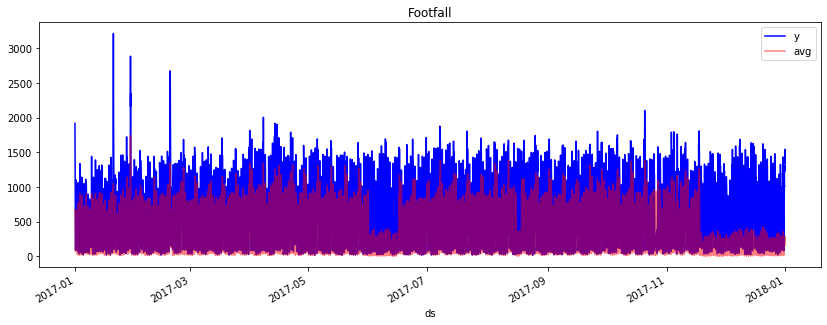

257.0931883228391
352.27815267448227


In [265]:
#K==3
Neighbor_distance = Neighbor_dist_df.loc[21,:].tolist()[0:4]
print(Neighbor[21])
#taking average
all_sensor_df = pedestrian_data[pedestrian_data.Sensor_ID == Neighbor[21][0]]
all_sensor_df = all_sensor_df[['ds','y']]


for n in Neighbor[21][1:3]:

    sensor_df = pedestrian_data[pedestrian_data.Sensor_ID == n]
    sensor_df = sensor_df[['ds','y']]
    all_sensor_df = pd.merge(all_sensor_df, sensor_df, how='outer', on = 'ds')

print(all_sensor_df)

#Uniform Weights - uncomment and run for uniform weights, make sure to comment inverse section below

# all_sensor_df['NonZero'] = np.sum(~np.isnan(all_sensor_df.iloc[:,1:5]),axis=1)
# all_sensor_df = all_sensor_df.replace(np.nan,0)
# all_sensor_df['Total'] = ((all_sensor_df.iloc[:,1] + all_sensor_df.iloc[:,2] 
#                           + all_sensor_df.iloc[:,3] #+ all_sensor_df.iloc[:,4]
#                           )).astype(int)
# all_sensor_df['avg'] = (all_sensor_df['Total']/all_sensor_df['NonZero']).astype(int)


#Inverse weights - uncomment and run for inverse weights, make sure to comment uniform section above 
arr = np.array(Neighbor_distance[0:3]  , dtype=np.float32)
arr = np.reciprocal(arr)
inverse_sum = sum(arr)
inverse = arr/inverse_sum


all_sensor_df['NonZero'] = np.sum(~np.isnan(all_sensor_df.iloc[:,1:4]),axis=1)
all_sensor_df = all_sensor_df.replace(np.nan,0)
all_sensor_df['avg'] = ((inverse[0] * all_sensor_df.iloc[:,1] + inverse[1] * all_sensor_df.iloc[:,2] 
                          + inverse[2] * all_sensor_df.iloc[:,3] # + inverse[3] * all_sensor_df.iloc[:,4]
                          )).astype(int)




pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21_2014_18_df.plot(kind='line', x='ds', y='y', color='blue', ax=ax)
all_sensor_df.plot(kind='line', x='ds', y='avg', color='red', ax=ax, alpha=0.5)
plt.title('Footfall')
plt.show()

#MAE
# print(sensor21_2014_18_df)

all_sensor_df.rename(columns = {'y':'y_z'}, inplace = True)
temp = pd.merge(sensor21_2014_18_df, all_sensor_df, how='inner' , on='ds')

temp['diff'] = temp['y'] - temp['avg']
mae = sum(abs(temp['diff']))/len(temp)
print(mae)
# temp

from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(temp['y'], temp['avg'])
rmse = math.sqrt(mse)
print(rmse)

# from sklearn.metrics import mean_absolute_percentage_error
# # print('MAPE =' ,mean_absolute_percentage_error(temp['y'], temp['avg']))
# # >>> from sklearn.metrics import mean_absolute_percentage_error
# y_true = [3, -0.5, 2, 7]
# y_pred = [2.5, 0.0, 2, 8]
# mean_absolute_percentage_error(y_true, y_pred)

<h4>Forecast : </h4>

In [243]:
Neighbor_Sensors = [sensor20,sensor30,sensor40,sensor52]
Neighbor = Neighbor_df[Neighbor_df.Sensor_ID == 21].iloc[:,0:4].values.tolist()[0]   #[20,30,40,52]
Models = {}
Future = {}
Forecast = {}
for i,n in enumerate(Neighbor):

    m = Prophet(growth = 'logistic')
    m.add_country_holidays(country_name='AU')
    m.add_seasonality(name='daily', period=0.1, fourier_order=2)
    m.add_seasonality(name='weekly', period=7, fourier_order=3)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='yearly', period=365, fourier_order=5)
    m.fit(Neighbor_Sensors[i])

    Models[n] = m
    
    future = m.make_future_dataframe(periods=365)
    future['cap'] = 3000
    future['floor'] = 0
    
    Future[n] = future
    
    
    forecast = m.predict(future)
    Forecast[n] = forecast


INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonal

                      ds      yhat_x      yhat_y  NonZero  Total  avg
0    2017-01-01 00:00:00  489.095058  637.496151        2   1126  563
1    2017-01-01 01:00:00  492.019071  630.864617        2   1122  561
2    2017-01-01 02:00:00  431.033189  560.197483        2    991  495
3    2017-01-01 03:00:00  378.742546  514.629073        2    893  446
4    2017-01-01 04:00:00  340.566848  459.043160        2    799  399
...                  ...         ...         ...      ...    ...  ...
9119 2018-12-27 23:00:00  405.634405    0.000000        1    405  405
9120 2018-12-28 23:00:00  510.724850    0.000000        1    510  510
9121 2018-12-29 23:00:00  530.792114    0.000000        1    530  530
9122 2018-12-30 23:00:00  377.022381    0.000000        1    377  377
9123 2018-12-31 23:00:00  309.937527    0.000000        1    309  309

[9124 rows x 6 columns]


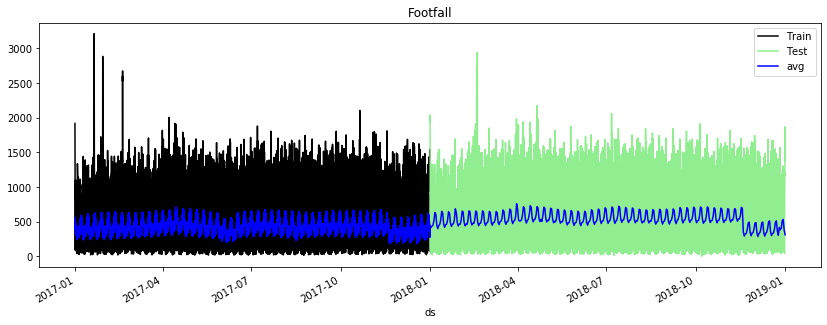

Mean Absoulte Error =  185.68493150684932
Root Mean Square Error =  247.8898396520917


In [254]:
# K=2
#taking average
avg = pd.merge(Forecast[30][['ds','yhat']], Forecast[20][['ds','yhat']], how='outer', on = 'ds')
avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:3]),axis=1)
avg = avg.replace(np.nan,0)
avg['Total'] = ((avg.iloc[:,1] + avg.iloc[:,2] 
                )).astype(int)
avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
print(avg)

sensor_21_test = pedestrian_data_test[pedestrian_data_test.Sensor_ID == 21]

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21.plot(kind='line', x='ds', y='y', color='black', ax=ax, label='Train')
sensor_21_test.plot(kind='line', x='ds', y='y', color='lightgreen', ax=ax, label='Test')
avg.plot(kind='line', x='ds', y='avg', color='blue', ax=ax)
plt.title('Footfall')
plt.show()

tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print("Root Mean Square Error = ", rmse)

                      ds      yhat_x      yhat_y        yhat  NonZero  Total  \
0    2017-01-01 00:00:00  489.095058  637.496151  131.530604        3   1258   
1    2017-01-01 01:00:00  492.019071  630.864617  141.502486        3   1264   
2    2017-01-01 02:00:00  431.033189  560.197483  100.307239        3   1091   
3    2017-01-01 03:00:00  378.742546  514.629073  120.456658        3   1013   
4    2017-01-01 04:00:00  340.566848  459.043160   58.069828        3    857   
...                  ...         ...         ...         ...      ...    ...   
9119 2018-12-27 23:00:00  405.634405    0.000000  187.857763        2    593   
9120 2018-12-28 23:00:00  510.724850    0.000000  141.383336        2    652   
9121 2018-12-29 23:00:00  530.792114    0.000000    1.251755        2    532   
9122 2018-12-30 23:00:00  377.022381    0.000000   58.311439        2    435   
9123 2018-12-31 23:00:00  309.937527    0.000000  144.346089        2    454   

      avg  
0     419  
1     421  
2  

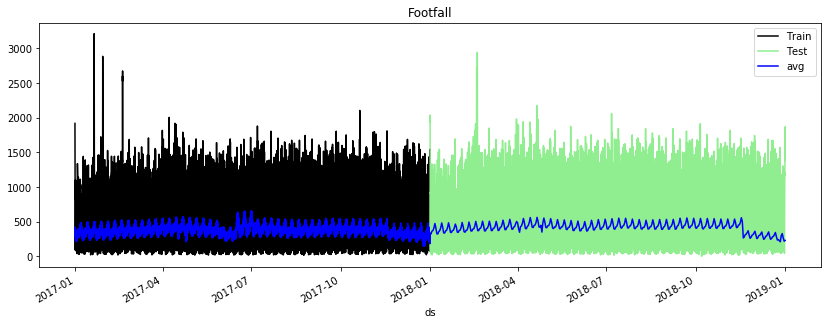

Mean Absoulte Error =  208.93698630136987
Root Mean Square Error =  312.6201949672635


In [258]:
 K=3
#taking average
avg = pd.merge(Forecast[30][['ds','yhat']], Forecast[20][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[40][['ds','yhat']], how='outer', on = 'ds')

avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:4]),axis=1)
avg = avg.replace(np.nan,0)
avg['Total'] = ((avg.iloc[:,1] + avg.iloc[:,2] + avg.iloc[:,3] 
                )).astype(int)
avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
print(avg)

sensor_21_test = pedestrian_data_test[pedestrian_data_test.Sensor_ID == 21]

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21.plot(kind='line', x='ds', y='y', color='black', ax=ax, label='Train')
sensor_21_test.plot(kind='line', x='ds', y='y', color='lightgreen', ax=ax, label='Test')
avg.plot(kind='line', x='ds', y='avg', color='blue', ax=ax)
plt.title('Footfall')
plt.show()

tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print("Root Mean Square Error = ", rmse)

<h3> Nearest Neighbor Forecast Location based </h3>

<h4>Forecast :</h4>

In [270]:
Neighbor_Sensors = [sensor20,sensor30,sensor19,sensor2]
Neighbor = [20,30,19,2]
Models = {}
Future = {}
Forecast = {}
for i,n in enumerate(Neighbor):

    m = Prophet(growth = 'logistic')
    m.add_country_holidays(country_name='AU')
    m.add_seasonality(name='daily', period=0.1, fourier_order=2)
    m.add_seasonality(name='weekly', period=7, fourier_order=3)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='yearly', period=365, fourier_order=5)
    m.fit(Neighbor_Sensors[i])

    Models[n] = m
    
    future = m.make_future_dataframe(periods=365)
    future['cap'] = 3000
    future['floor'] = 0
    
    Future[n] = future
    
    
    forecast = m.predict(future)
    Forecast[n] = forecast

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonal

In [271]:
#K = 4
#taking average
avg = pd.merge(Forecast[20][['ds','yhat']], Forecast[30][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[19][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[2][['ds','yhat']], how='outer', on = 'ds')

avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:5]),axis=1)
avg = avg.replace(np.nan,0)
avg['Total'] = ((avg.iloc[:,1] + avg.iloc[:,2] + avg.iloc[:,3] + avg.iloc[:,4]
                )).astype(int)
avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
avg



/home/mufaddal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'yhat_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


,ds,yhat_x,yhat_y,yhat_x,yhat_y,NonZero,Total,avg
0,2017-01-01 00:00:00,489.095058,637.496151,776.766432,1041.803257,4,2945,736
1,2017-01-01 01:00:00,492.019071,630.864617,791.787506,978.779450,4,2893,723
2,2017-01-01 02:00:00,431.033189,560.197483,710.491300,814.542922,4,2516,629
3,2017-01-01 03:00:00,378.742546,514.629073,628.533624,827.533679,4,2349,587
4,2017-01-01 04:00:00,340.566848,459.043160,567.183411,813.489466,4,2180,545
...,...,...,...,...,...,...,...,...
9119,2018-12-27 23:00:00,405.634405,0.000000,620.362537,1238.296102,3,2264,754
9120,2018-12-28 23:00:00,510.724850,0.000000,787.255936,1352.779652,3,2650,883
9121,2018-12-29 23:00:00,530.792114,0.000000,799.218710,1110.476709,3,2440,813
9122,2018-12-30 23:00:00,377.022381,0.000000,622.023661,951.176823,3,1950,650


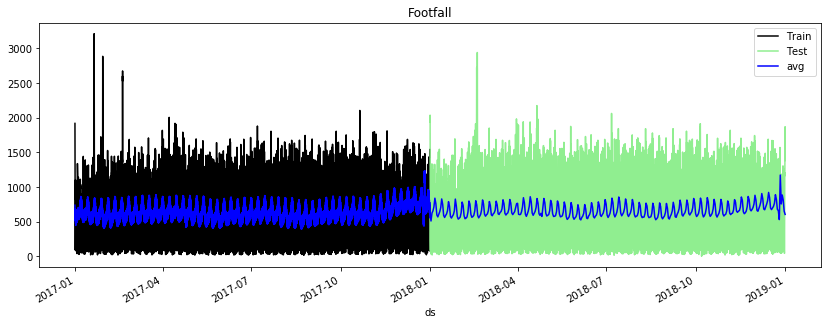

In [79]:


pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
sensor21.plot(kind='line', x='ds', y='y', color='black', ax=ax, label='Train')
sensor_21_test.plot(kind='line', x='ds', y='y', color='lightgreen', ax=ax, label='Test')
avg.plot(kind='line', x='ds', y='avg', color='blue', ax=ax)
plt.title('Footfall')
plt.show()

In [80]:
tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
print(cust_mse)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print(mse , rmse)

Mean Absoulte Error =  215.85479452054796
64541.180821917806
64541.180821917806 254.04956371133136


In [82]:
# K = 3
#taking average
avg = pd.merge(Forecast[20][['ds','yhat']], Forecast[30][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[19][['ds','yhat']], how='outer', on = 'ds')
# avg = pd.merge(avg, Forecast[2][['ds','yhat']], how='outer', on = 'ds')

avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:4]),axis=1)
avg = avg.replace(np.nan,0)
avg['Total'] = ((avg.iloc[:,1] + avg.iloc[:,2] + avg.iloc[:,3] #+ avg.iloc[:,4]
                )).astype(int)
avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
avg



,ds,yhat_x,yhat_y,yhat,NonZero,Total,avg
0,2017-01-01 00:00:00,489.095058,637.496151,776.766432,3,1903,634
1,2017-01-01 01:00:00,492.019071,630.864617,791.787506,3,1914,638
2,2017-01-01 02:00:00,431.033189,560.197483,710.491300,3,1701,567
3,2017-01-01 03:00:00,378.742546,514.629073,628.533624,3,1521,507
4,2017-01-01 04:00:00,340.566848,459.043160,567.183411,3,1366,455
...,...,...,...,...,...,...,...
9119,2018-12-27 23:00:00,405.634405,0.000000,620.362537,2,1025,512
9120,2018-12-28 23:00:00,510.724850,0.000000,787.255936,2,1297,648
9121,2018-12-29 23:00:00,530.792114,0.000000,799.218710,2,1330,665
9122,2018-12-30 23:00:00,377.022381,0.000000,622.023661,2,999,499


In [83]:
tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
print(cust_mse)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print(mse , rmse)

Mean Absoulte Error =  177.62191780821917
54369.00821917808
54369.00821917808 233.17162824661597


In [87]:
# inverse distance 
#k=4
# arr = np.array([1/134 , 1/236 , 1/256 , 1/322], dtype=np.float32)
# inverse_sum = 1/134 + 1/236 + 1/256 + 1/322
#k=3
arr = np.array([1/134 , 1/236 , 1/256 ], dtype=np.float32)
inverse_sum = 1/134 + 1/236 + 1/256

inverse = arr/inverse_sum


#taking average
avg = pd.merge(Forecast[20][['ds','yhat']], Forecast[30][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[19][['ds','yhat']], how='outer', on = 'ds')
# avg = pd.merge(avg, Forecast[2][['ds','yhat']], how='outer', on = 'ds')

avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:4]),axis=1)
avg = avg.replace(np.nan,0)

avg['avg'] = ((inverse[0] * avg.iloc[:,1] + inverse[1] * avg.iloc[:,2] + inverse[2] * avg.iloc[:,3] #+ inverse[3] * avg.iloc[:,4]
                )).astype(int)
# avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
avg

,ds,yhat_x,yhat_y,yhat,NonZero,avg
0,2017-01-01 00:00:00,489.095058,637.496151,776.766432,3,601
1,2017-01-01 01:00:00,492.019071,630.864617,791.787506,3,604
2,2017-01-01 02:00:00,431.033189,560.197483,710.491300,3,536
3,2017-01-01 03:00:00,378.742546,514.629073,628.533624,3,478
4,2017-01-01 04:00:00,340.566848,459.043160,567.183411,3,429
...,...,...,...,...,...,...
9119,2018-12-27 23:00:00,405.634405,0.000000,620.362537,2,349
9120,2018-12-28 23:00:00,510.724850,0.000000,787.255936,2,441
9121,2018-12-29 23:00:00,530.792114,0.000000,799.218710,2,453
9122,2018-12-30 23:00:00,377.022381,0.000000,622.023661,2,335


In [88]:
tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
print(cust_mse)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print(mse , rmse)

Mean Absoulte Error =  184.2109589041096
63279.953424657535
63279.953424657535 251.55507036165568


In [90]:
# inverse distance 
#k=4
arr = np.array([1/134 , 1/236 , 1/256 , 1/322], dtype=np.float32)
inverse_sum = 1/134 + 1/236 + 1/256 + 1/322
#k=3
# arr = np.array([1/134 , 1/236 , 1/256 ], dtype=np.float32)
# inverse_sum = 1/134 + 1/236 + 1/256

inverse = arr/inverse_sum


#taking average
avg = pd.merge(Forecast[20][['ds','yhat']], Forecast[30][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[19][['ds','yhat']], how='outer', on = 'ds')
avg = pd.merge(avg, Forecast[2][['ds','yhat']], how='outer', on = 'ds')

avg['NonZero'] = np.sum(~np.isnan(avg.iloc[:,1:4]),axis=1)
avg = avg.replace(np.nan,0)

avg['avg'] = ((inverse[0] * avg.iloc[:,1] + inverse[1] * avg.iloc[:,2] + inverse[2] * avg.iloc[:,3] + inverse[3] * avg.iloc[:,4]
                )).astype(int)
# avg['avg'] = (avg['Total']/avg['NonZero']).astype(int)
avg

/home/mufaddal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'yhat_x'} in the result is deprecated and will raise a MergeError in a future version.
  from ipykernel import kernelapp as app


,ds,yhat_x,yhat_y,yhat_x,yhat_y,NonZero,avg
0,2017-01-01 00:00:00,489.095058,637.496151,776.766432,1041.803257,3,674
1,2017-01-01 01:00:00,492.019071,630.864617,791.787506,978.779450,3,666
2,2017-01-01 02:00:00,431.033189,560.197483,710.491300,814.542922,3,582
3,2017-01-01 03:00:00,378.742546,514.629073,628.533624,827.533679,3,536
4,2017-01-01 04:00:00,340.566848,459.043160,567.183411,813.489466,3,493
...,...,...,...,...,...,...,...
9119,2018-12-27 23:00:00,405.634405,0.000000,620.362537,1238.296102,2,496
9120,2018-12-28 23:00:00,510.724850,0.000000,787.255936,1352.779652,2,592
9121,2018-12-29 23:00:00,530.792114,0.000000,799.218710,1110.476709,2,562
9122,2018-12-30 23:00:00,377.022381,0.000000,622.023661,951.176823,2,438


In [91]:
tmp = pd.merge(avg,sensor_21_test , how='inner', on = 'ds')
tmp['mse'] = np.square(tmp['y'] - tmp['avg'])
mae = np.sum(np.abs(tmp['y'] - tmp['avg']))/len(tmp)
print("Mean Absoulte Error = ",mae)
cust_mse = np.sum(tmp['mse'])/len(tmp)
print(cust_mse)
mse = mean_squared_error(tmp['y'], tmp['avg'])
rmse = math.sqrt(mse)
print(mse , rmse)

Mean Absoulte Error =  188.05479452054794
57517.0301369863
57517.0301369863 239.82708382704882
